# SuperStore Sales Forecasting 

<p aling='justify'> This analysis provide sales forecasting basing on super store dataset.</p>

Table of contents:
1. Notebook setup and modules import 
2. Data preprocessing
3. Data analysis and visualisation 
4. Stationarity analysis 
5. Trend & seasonality analysis
6. Differencing and trend decomposition 
7. AR, MA, ARIMA, SARIMAX
8. Best model selecetion and forecasts
9. Summary

### 1. Notebook setup and modules import

In [74]:
%pip install Config/requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'Config/requirements.txt'


In [75]:
%load_ext sql 

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [76]:
%sql mssql+pyodbc://PLLUKOR1@local

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

In [78]:
%sql use SuperStore;

 * mssql+pyodbc://PLLUKOR1@local
Done.


[]

### 2. Data preprocessing

In [ ]:
query = '''
SELECT CAST(OderDate as DATE) as Date
        ,Sales
FROM Orders
ORDER BY Date
'''
results = %sql $query
results = pd.DataFrame(results)
results['Sales'] = results['Sales'].astype(np.float64)
results['Date'] = pd.to_datetime(results['Date'], format= "%Y-%m-%d")
results.set_index('Date', inplace=True)
data = results

### 3. Data Analysis and Visualisation 

<p aling='justify'>To perform data preprocessing and time series forecasting properly, sufficient amount of sample is required. During the differencing process some cases are lost, so it is important to have as many data samples as possible with high flexibility according to generealization. SuperSotre dataset includes sales data for range of 4 years. Chosing proper basis is a key factor for time series forecasting and it is first step to do before kicking-off forecasting task. <p> 

In [147]:
xlines = ['2014-02-01','2014-08-01', '2015-02-01', '2015-08-01','2016-02-01', '2016-08-01','2017-02-01', '2017-08-01']

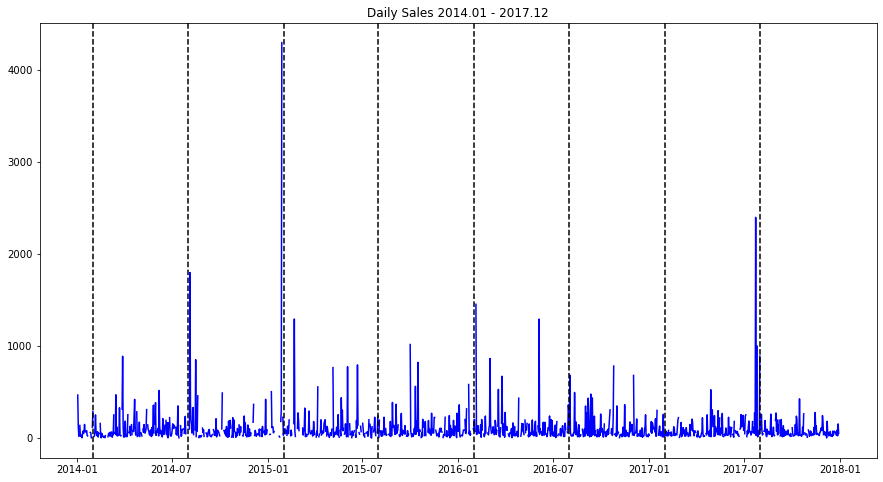

In [157]:
dailyData = data.resample('1D')
dailyData = dailyData.agg({'Sales':'median'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(dailyData, color='blue')
axes.set_title('Daily Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

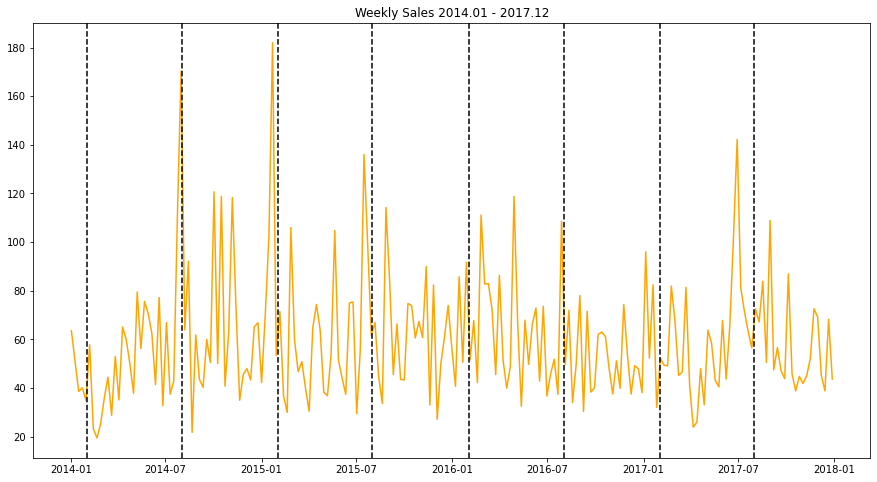

In [155]:
weeklyData = data.resample('7D')
weeklyData = weeklyData.agg({'Sales':'median'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(weeklyData, color='orange')
axes.set_title('Weekly Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

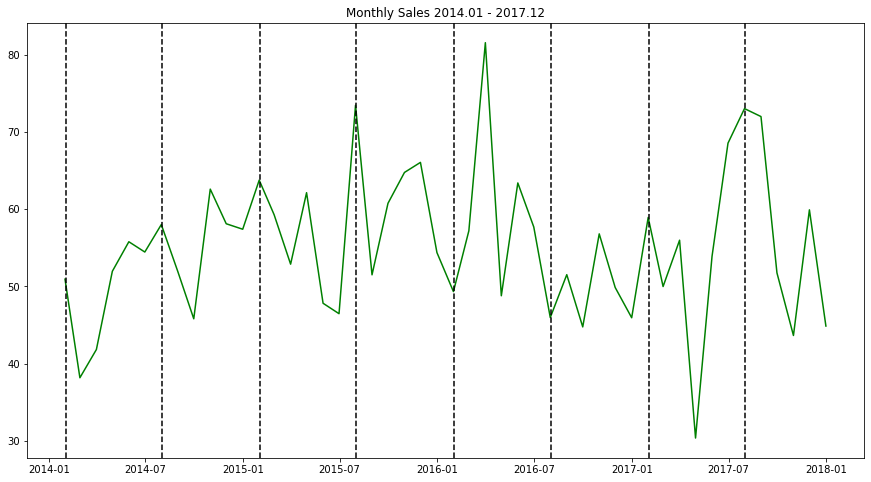

In [152]:
monthlyData = data.resample('1M')
monthlyData = monthlyData.agg({'Sales':'median'})

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(monthlyData, color='green')
axes.set_title('Monthly Sales 2014.01 - 2017.12')
for line in xlines:
    plt.axvline(x=line, color='black', linestyle='--')
plt.show()

### 4. Stationary analysis

To test time series stationarity adfuler test has to be involved.

*H<sub>0</sub>: Time series is not stationary, there is unit root*
<br>
*H<sub>1</sub>: Time series is  stationary, there is no unit root*

In [156]:
from statsmodels.tsa.stattools import adfuller

In [168]:
def stationaryTest(sales):
    test = adfuller(sales)

    statistics = ['ADF', 'P-value', 'Lags', 'Samples']
    for value, statistic in zip(test, statistics):
        print(f'{statistic} : {value}')

    if test[1] <= 0.05:
        print(f'P-value = {test[1]:.2f}\nStrong evidence aganist null hypothesis. Null hypothesis rejected - data is stationary.')
    else:
        print(f'P-value = {test[1]:.2f}\nWeak evidence aganist null hypothesis. Null hypothesis accepted - data is not stationary.')


In [172]:
stationaryTest(monthlyData)

ADF : -5.8634559631329966
P-value : 3.3680767486371186e-07
Lags : 0
Samples : 47
P-value = 0.00
Strong evidence aganist null hypothesis. Null hypothesis rejected - data is stationary.


### 5. Trend and seasonality analysis